# Module 6 Practice 1 - Grid searching the best Random Forest classifier

In the labs we saw that the random forest performed the best using mostly deafult parameters for the model.  In this practice, you will use a grid search to see if the model can be improved with different model hyper parameters.  We will continue to use the same dataset to predict 30 day hospital readmission.

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

## Apply transformations to our data
These are the same transformations as applied in the labs.  See Lab 1 for more explanations.

In [3]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../resources/diabetes_readmission.csv')
display(data.head())

y = data['readmitted']
X = data[['discharge', 'age', 'race', 'admission_type', 'specialty', 'time_in_hospital', 'diag_1', 'A1Cresult', 'change']].copy()

scaler = StandardScaler()
X['time_in_hospital'] = scaler.fit_transform(X[['time_in_hospital']])

# create dummy variables
X = pd.concat([X, pd.get_dummies(X['age'], prefix = 'age', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['race'], prefix = 'race', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['admission_type'], prefix = 'admission_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['specialty'], prefix = 'specialty', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['diag_1'], prefix = 'diag_1', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['A1Cresult'], prefix = 'A1Cresult', drop_first=True)], axis=1)

# drop originals
X = X.drop(['age', 'race', 'admission_type', 'specialty', 'diag_1', 'A1Cresult'], axis=1)

# balance the classes
display(y.value_counts())

X_oversampled, y_oversampled = resample(X[y == 1], y[y == 1], replace=True, n_samples=X[y == 0].shape[0], random_state=42)

X = pd.DataFrame(np.vstack((X[y == 0], X_oversampled)), columns=X.columns)
y = np.hstack((y[y == 0], y_oversampled))

display(pd.Series(y).value_counts())

,readmitted,discharge,age,race,admission_type,specialty,time_in_hospital,diag_1,A1Cresult,change
0,1,0,0,1,1,0,8,8,0,1
1,0,0,0,1,1,4,2,8,0,0
2,0,1,2,1,1,2,4,8,2,0
3,0,0,2,1,1,2,3,8,3,1
4,0,0,0,0,1,2,5,8,0,0


0    60145
1     5813
Name: readmitted, dtype: int64

1    60145
0    60145
dtype: int64

## Perform a grid search using cross validation
Perform a grid search of the following parameters:

* n_estimators - the number of trees to generate
* criterion - the method for determing the quality of a split in the tree
* max_depth - the mximum number of splits in the tree

Refer to the [documentation for RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for the valid values for these parameters.  You may select any set of values that you feel are appropriate.

Initialize the model with a random_state for reproducible results.

For scoring the grid search, we will use both accuracy and AUC for selecting the best set of parameters.  The values to specify for these can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).  Refer to the documentation for [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py) to see how to specify multiple metrics.  Use the AUC as the final metric for refitting.

Depending on the number of parameter options you specify in the grid search, this process could take some time.

In [4]:
# your code here

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 30, None],
}


model = RandomForestClassifier(random_state=42)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring={'acc': 'accuracy','auc': 'roc_auc'}, refit='auc')
grid_result = grid.fit(X, y)

print("Best model: %f with parameters %s" % (grid_result.best_score_, grid_result.best_params_))



Best model: 0.722418 with parameters {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 500}


## Get the best model from the grid search
Get the best model, print the accuracy, and visualize the ROC curve.

accuracy 0.6827167678111231


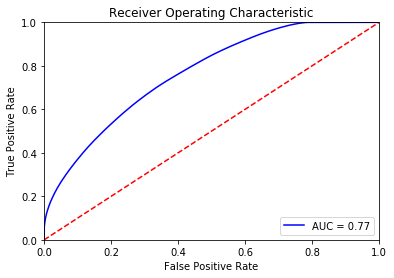

In [5]:
# your code here

from sklearn import metrics
import matplotlib.pyplot as plt

model = grid.best_estimator_

print('accuracy', model.score(X, y))

probs = model.predict_proba(X)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
